# 📈 **K-means Clustering for Pair Trading Stock Selection**  
#### *Using Cointegration, Correlation, and K-means Clustering*

---

## 🧠 **Introduction**

This project focuses on selecting stocks from the **S&P 500** for **Pair Trading**, leveraging both **short-term** and **long-term** statistical relationships between assets.  
It aims to **reduce data complexity** and **optimize analysis efficiency** through a systematic pipeline involving clustering, filtering, and statistical tests.

---

## 🔄 **Workflow Overview**

### 1️⃣ **Data Retrieval**
- Retrieve historical stock prices of S&P 500  using `yfinance` over the specified period.

### 2️⃣ **Calculate Investment Indicators**
- Compute **Annual Return Rate** and **Volatility** for each stock to assess investment characteristics.

### 3️⃣ **Dimensionality Reduction with K-means Clustering**

- Group stocks based on similar return and volatility profiles using **K-means clustering**  
  to filter out stocks that do not share comparable risk–return characteristics.
- Determine optimal cluster count using:  
  - **Elbow Method**  
  - **Silhouette Score**
  

### 4️⃣ **Relationship Screening: Cointegration & Correlation**
- Within each cluster:
  - 📌 **Cointegration**: Identify long-term equilibrium relationships between stock pairs.
  - 📌 **Correlation**: Assess linear relationships and retain highly correlated pairs based on a predefined threshold.
  
### 5️⃣ **Pair Selection for Trading**
- Filter and finalize statistically viable stock pairs that pass both **Cointegration** and **Correlation** criteria.

---

### 📌 Data Source & Update Mechanism 

The stock ticker data is sourced directly from **Google Sheets**, allowing for seamless integration with the screening system.

Whenever updates are made to the sheet, the system **automatically synchronizes** the changes — ensuring that all screening criteria are applied to the most recent data.

---

## 🚀 **Application & Benefits**

- Efficiently **filter irrelevant assets** from large datasets.
- Reduce **market noise** by focusing only on statistically consistent stock relationships.
- Provide **actionable insights** for deploying robust Pair Trading strategies.

---


✅ *Outcome*: A streamlined, data-driven approach to identify optimal stock pairs for trading, tailored to the dynamics of the stocks within the S&P 500.


<br>

<br>

### Import Libary

In [1]:
import pandas as pd
import numpy as np

# Conintregration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from kneed import KneeLocator # find the optimal cluster
from sklearn.metrics import silhouette_score
from sklearn import metrics

# Visualizations 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Connect Google Sheet
import gspread
from oauth2client.service_account import ServiceAccountCredentials

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

<br>

<br>

### Build Necessary Function

In [2]:
def calculate_cointegration_and_correlation(price_asset1, price_asset2, expected_critical_value=0.05):
    '''
     Function to calculate Cointegration and Correlation
     
    coint_flag == 1 : that 2 assets are cointegrate
    coint_flag == 0 : that 2 assets are not cointegrate
    
    '''
    coint_flag = 0
    # Calculate Cointegration
    coint_result = sm.tsa.coint(price_asset1, price_asset2)
    coint_test = coint_result[0]
    p_value = coint_result[1]
    critical_value = coint_result[2][1]
    
    # Calculate hedge ratio
    model = sm.OLS(price_asset1, price_asset2).fit()
    hedge_ratio = model.params[0]

    # Convert to pandas Series for correlation calculation
    price_asset1_series = pd.Series(price_asset1)
    price_asset2_series = pd.Series(price_asset2)

    # Calculate Correlation
    correlation = price_asset1_series.corr(price_asset2_series)
    
    # Determine if the assets are cointegrated based on p_value and critical_value
    coint_flag = 1 if p_value < expected_critical_value and coint_test < critical_value else 0
    
    return coint_flag, hedge_ratio, coint_test, correlation

<br>

<br>

### Initail Parameter

#### Time Period

In [3]:
interval='1d'
period='5y'

#### Stock Buckets 

##### Fetch Tickers data from Google Sheet

In [4]:
scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive"
]

creds = ServiceAccountCredentials.from_json_keyfile_name(
    "C:/Users/armys/Downloads/gen-lang-client-0544819307-3ccec4ef6e99.json",
    scope
)

client = gspread.authorize(creds)
sheet = client.open("SP500Tickers").worksheet("sheet1")
data_Tickers = pd.DataFrame(sheet.get_all_records())
df_Tickers = data_Tickers[:]
df_Tickers

,Ticker
0,A
1,AAL
2,AAPL
3,ABBV
4,ABNB
...,...
499,YUM
500,ZBH
501,ZBRA
502,ZTS


##### Data Manipulations & Pre-Processing

In [5]:
ticker_list =df_Tickers['Ticker'].to_list()
print(ticker_list[:5])

['A', 'AAL', 'AAPL', 'ABBV', 'ABNB']


<br>

<br>

### Fetch Historical Data

In [6]:
# Assume that ticker_list is already defined
stock_data = {}

# Required columns to extract
required_columns = ['Close']

for ticker in ticker_list:
    try:
        # Download stock data
        df_loop = yf.download(tickers=ticker, period=period, interval=interval)

        # Skip if the DataFrame is empty
        if df_loop.empty:
            print(f"⚠️ No data found for {ticker}")
            continue

        # If MultiIndex columns exist, drop the second level (ticker symbol)
        if isinstance(df_loop.columns, pd.MultiIndex):
            df_loop = df_loop.droplevel(1, axis=1)

        # Keep only required columns if available
        if set(required_columns).issubset(df_loop.columns):
            df_loop = df_loop[required_columns]
            stock_data[ticker] = df_loop
        else:
            print(f"⚠️ Missing required columns for {ticker}")

    except Exception as e:
        print(f"❌ Error fetching data for {ticker}: {e}")

# Combine all stock data into a single DataFrame with MultiIndex columns
if stock_data:
    stock_df = pd.concat(stock_data, axis=1)
    stock_df.columns.names = ['Ticker', 'Price']  # Set column level names

    # Convert MultiIndex columns to single-level with format: Close_{TICKER}
    stock_df.columns = [f"{price}_{ticker}" for ticker, price in stock_df.columns]
else:
    print("❌ No valid data retrieved for any ticker.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

⚠️ No data found for CTLT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

⚠️ No data found for MRO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<br>

<br>

### Feature Engineering

<br>

##### Calculate CAGR & Volatility 

In [7]:
df_returns = pd.DataFrame((1 + stock_df.pct_change()).prod() ** (252 / len(stock_df)) - 1,columns=['Returns'])
df_returns['Volatility'] = stock_df.pct_change().std() * np.sqrt(252)
df_returns.tail()

,Returns,Volatility
Close_YUM,0.203647,0.217302
Close_ZBH,0.048283,0.283058
Close_ZBRA,0.092322,0.377046
Close_ZTS,0.089835,0.265972
Close_NDX,0.217927,0.233315


<br>

<br>

###  Z - Score 

In [8]:
scaler = StandardScaler()
df_scaler = scaler.fit_transform(df_returns)
scaler_data = pd.DataFrame(df_scaler,columns=df_returns.columns , index = df_returns.index)
df_scaled = scaler_data.copy()
df_scaled.head()

,Returns,Volatility
Close_A,-0.406474,-0.526793
Close_AAL,-1.549587,2.575064
Close_AAPL,0.893343,-0.390619
Close_ABBV,0.735043,-1.064153
Close_ABNB,-1.429303,1.730299


<br>

<br>

### Model Creation 🧩 
#### K-means++ Clustering for Dimensionality Reduction and Optimal Cluster Selection

Optimum Cluster: 5
Silhouette Score for Optimal Cluster (5 clusters): 0.3506


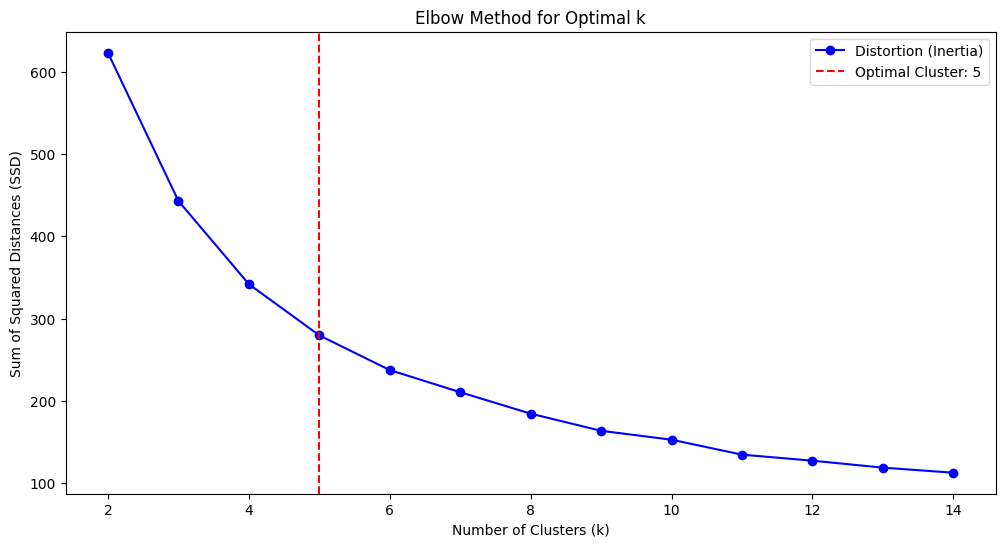

In [9]:
# Initialize parameters
X = df_scaled.copy()
K = range(2, 15) # Number of Clusters

ssd = []

# Calculate SSD (Sum of Squared Distances) for each number of clusters
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=False)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

# Find the optimal number of clusters using the Elbow Method
kl = KneeLocator(K, ssd, curve='convex', direction='decreasing')
c = kl.elbow
print('Optimum Cluster:', c)

# Calculate Silhouette Score for the optimal number of clusters
optimal_kmeans = KMeans(n_clusters=c, init='k-means++', random_state=False)
optimal_kmeans.fit(X)
silhouette_avg = silhouette_score(X, optimal_kmeans.labels_)
print(f'Silhouette Score for Optimal Cluster ({c} clusters): {silhouette_avg:.4f}')

# Plot the Elbow Method graph with the optimal point marked
plt.figure(figsize=(12, 6))
plt.plot(K, ssd, 'bo-', markersize=6, label='Distortion (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method for Optimal k')

# Draw a vertical line at the optimal k point
plt.axvline(x=c, color='red', linestyle='--', label=f'Optimal Cluster: {c}')

# Add legend
plt.legend()
plt.show()

<br>

<br>




#### Visualizasion Centroids of Optimal Cluster

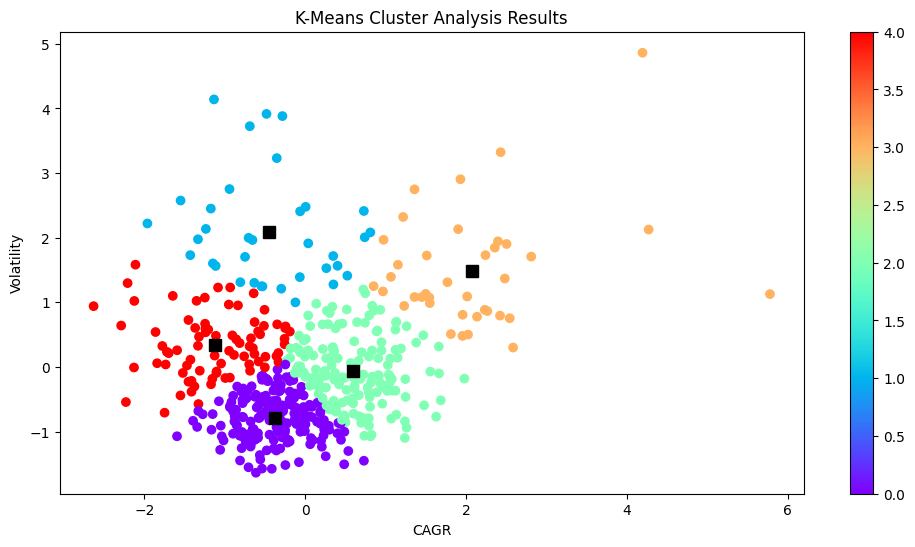

In [10]:
#prediction = optimal_kmeans.predict(X)
centroids = optimal_kmeans.cluster_centers_
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1],c=optimal_kmeans.labels_,cmap='rainbow',label=X.index)
ax.set_title('K-Means Cluster Analysis Results')
ax.set_xlabel('CAGR')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sk',markersize=9)
plt.show()

<br>

<br>

### 📊 Cluster Visualization  
#### Display Assigned Cluster Numbers for Each Stock

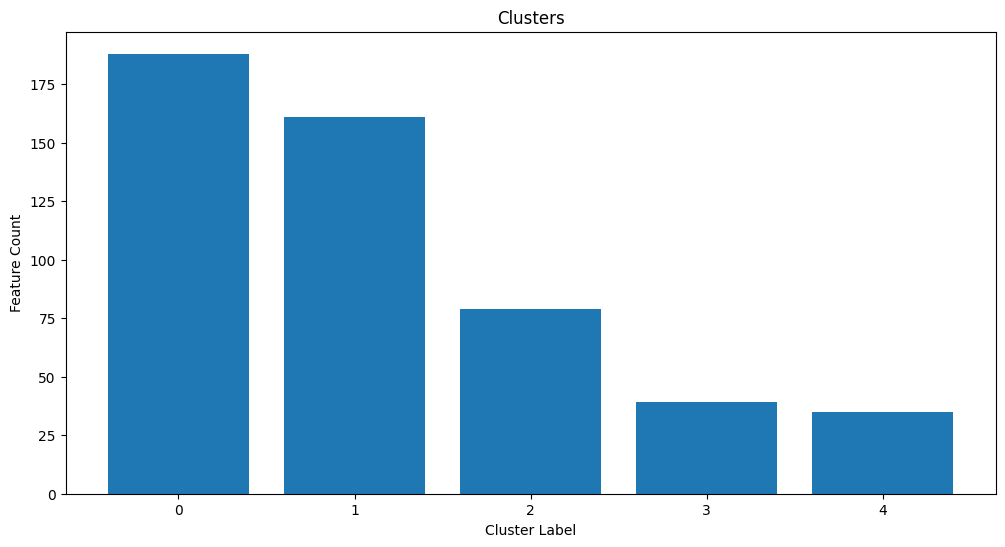

In [11]:
clustered_series = pd.Series(index=X.index,data=optimal_kmeans.labels_.flatten())
clustered_series_all = pd.Series(index=X.index,data=optimal_kmeans.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]


# View Number by Cluster
plt.figure(figsize=(12,6))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Feature Count')
plt.show()

<br>

#### Count Asset Number Before & After Screening

In [12]:
# screen out the feature label that less than  group_lebel_screening_number
cut_the_group_that_more_than = 3

# Remove items if Preferred
cluster_clean = clustered_series[clustered_series < cut_the_group_that_more_than]

print('Asset (Feature) Number Before Screening :',len(clustered_series))
print('Asset (Feature) Number After Screening :',len(cluster_clean))

Asset (Feature) Number Before Screening : 502
Asset (Feature) Number After Screening : 384


<br>

<br>

<br>

### Cointegration & Correlation Screening

In [13]:
# Loop Through and Calculate cointegrated pairs with Correlation
correlation_threshold = 0.8
load_coint_pairs = False
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in cluster_clean.index:
        base_label = cluster_clean[base_asset]
        
        for compare_asset in cluster_clean.index:
            compare_label = cluster_clean[compare_asset]
            
            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)
            
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                # Clean data to handle NaN and Infinite values
                series_1 = pd.Series(stock_df[base_asset].values.astype(float)).replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
                series_2 = pd.Series(stock_df[compare_asset].values.astype(float)).replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')

                
                # Calculate cointegration, hedge ratio, cointegration test, and correlation
                coint_flag, hedge_ratio, coint_value, correlation = calculate_cointegration_and_correlation(series_1, series_2)
                
                if coint_flag == 1:
                    cointegrated_pairs.append({
                        "base_asset": base_asset,
                        "compare_asset": compare_asset,
                        "label": base_label,
                        "coint": coint_value,
                        "correlation": correlation  # Add correlation to the output
                    })

df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
df_coint_pass = df_coint[df_coint['correlation'] > correlation_threshold]
df_coint_pass = df_coint_pass.sort_values(by='coint', ascending=True)
display(df_coint_pass)

,base_asset,compare_asset,label,coint,correlation
240,Close_AMAT,Close_NXPI,2,-5.647879,0.971172
1174,Close_DGX,Close_NDAQ,0,-5.602122,0.904423
323,Close_AMCR,Close_O,0,-5.336443,0.860679
1173,Close_DGX,Close_MO,0,-5.133816,0.840604
1181,Close_DGX,Close_PM,0,-5.108821,0.858655
...,...,...,...,...,...
213,Close_AIZ,Close_CME,0,-3.344538,0.879203
1628,Close_HIG,Close_MSI,2,-3.344537,0.968913
964,Close_CMG,Close_MSFT,2,-3.343900,0.958346
2154,Close_KKR,Close_NOW,2,-3.343773,0.951634


<br>

### 🔗 High Cointegration & Correlation Pair Visualization

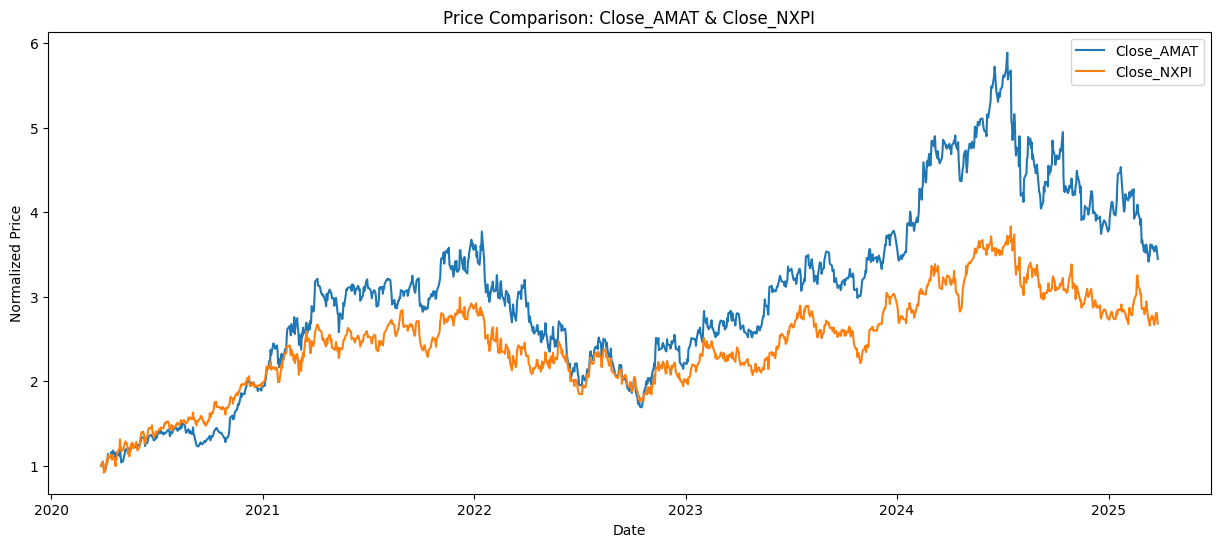

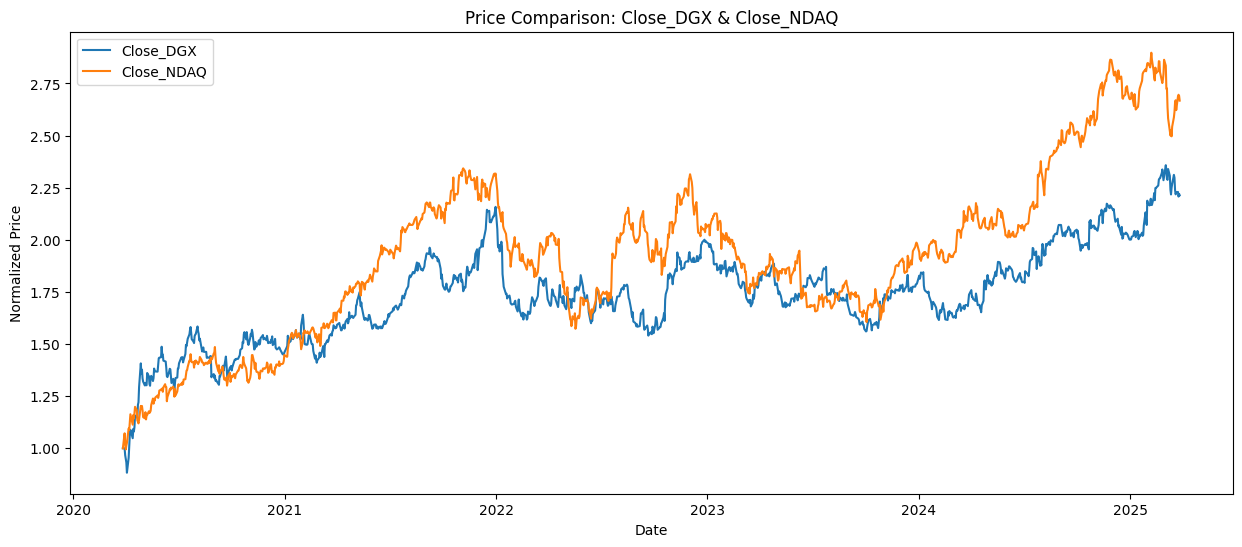

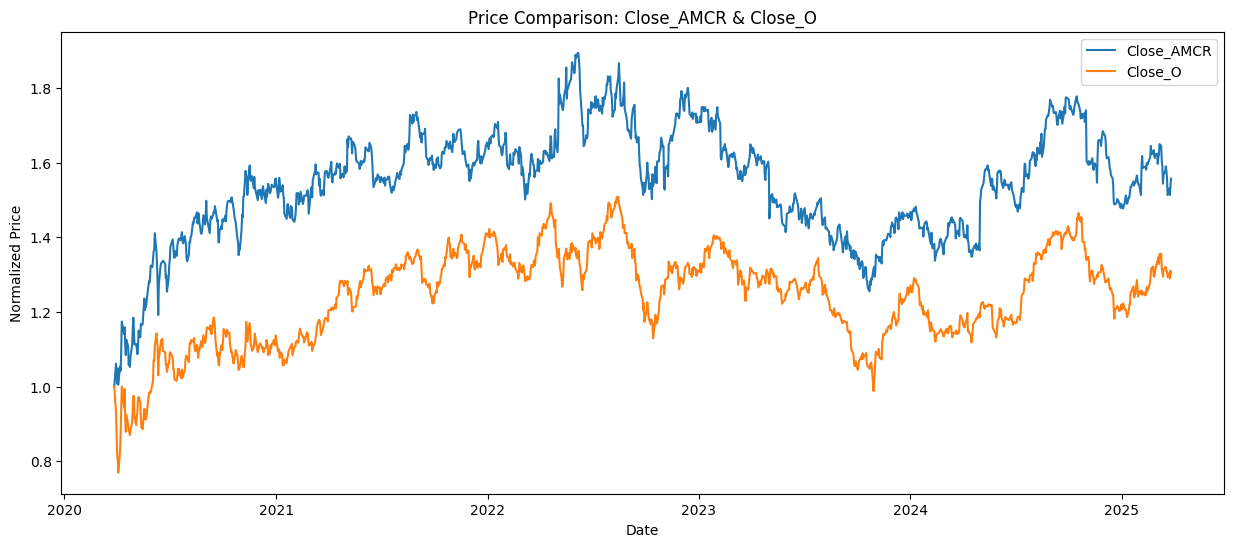

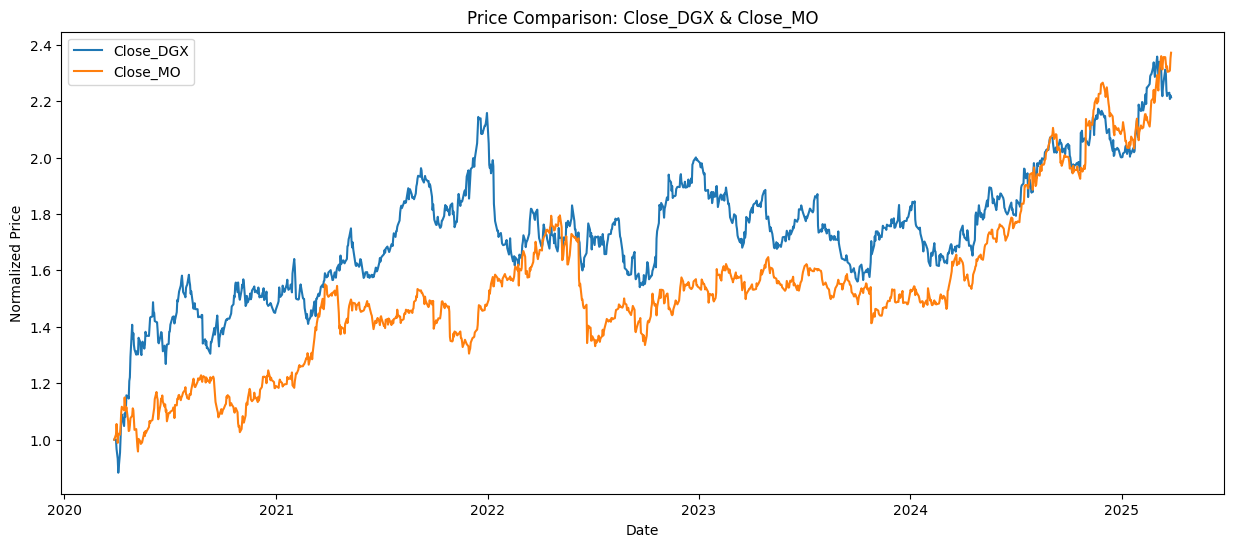

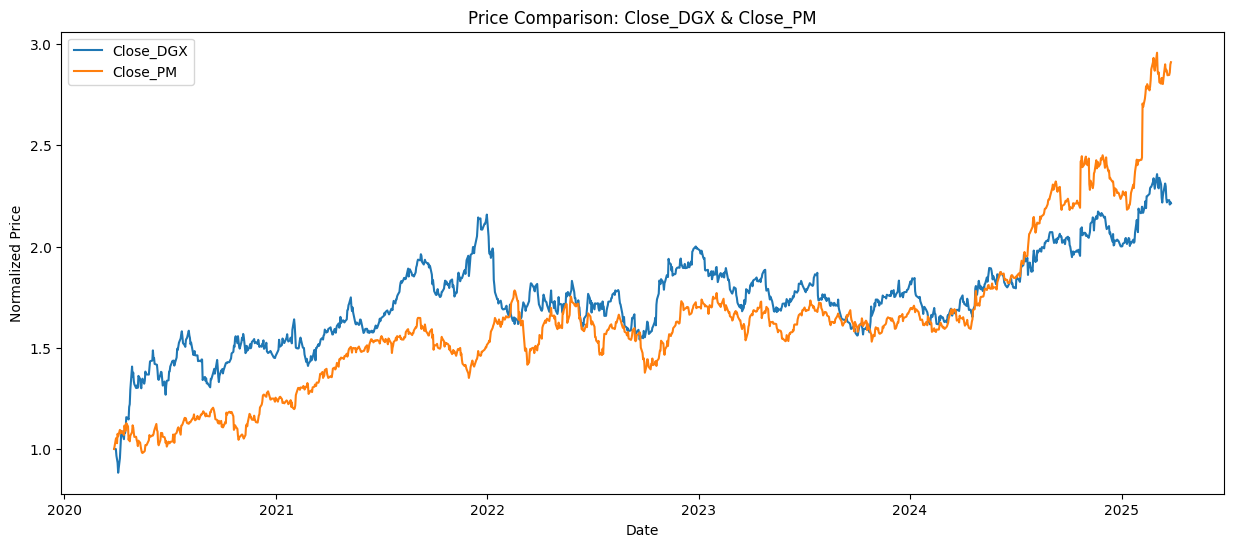

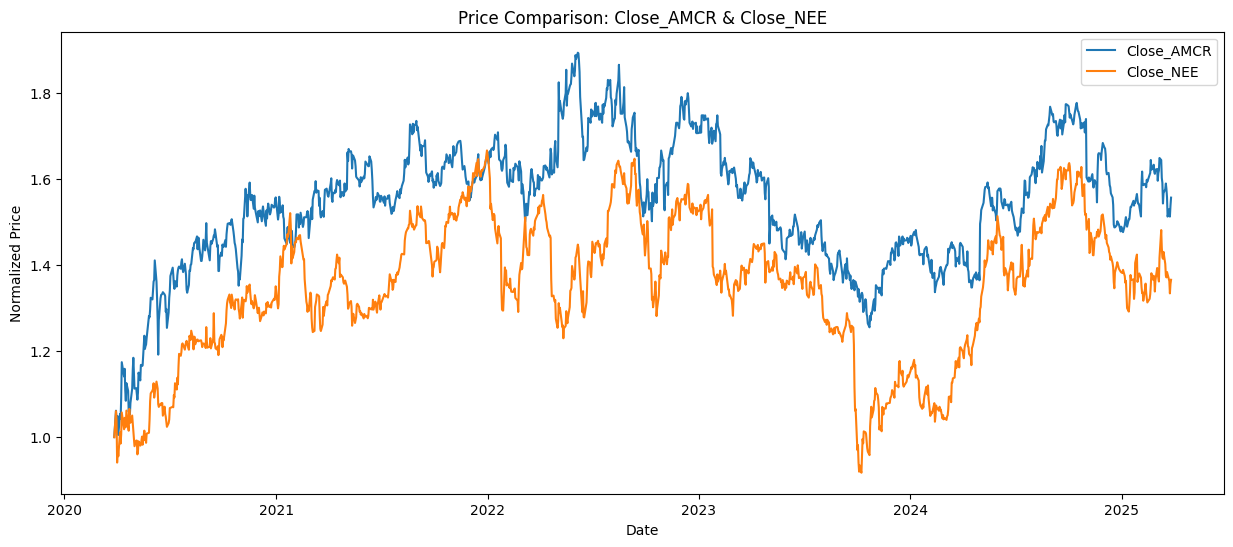

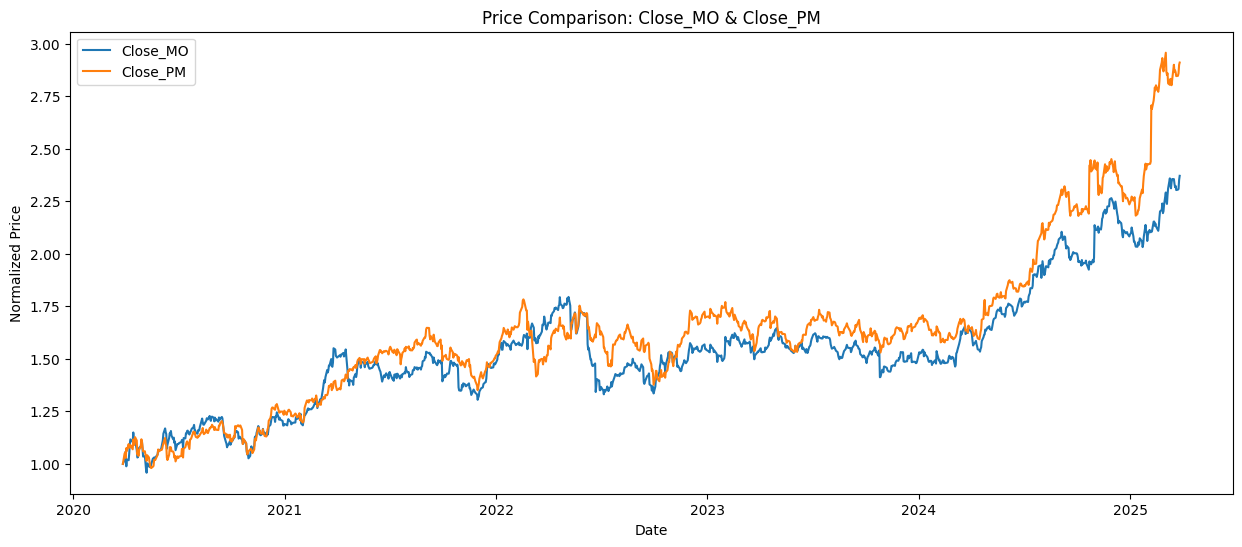

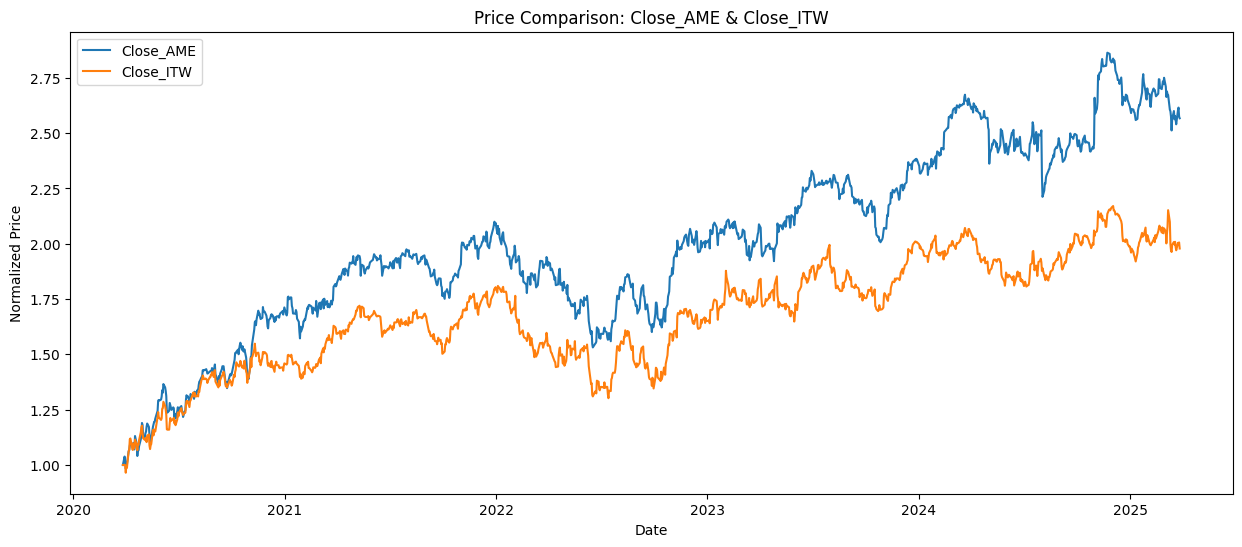

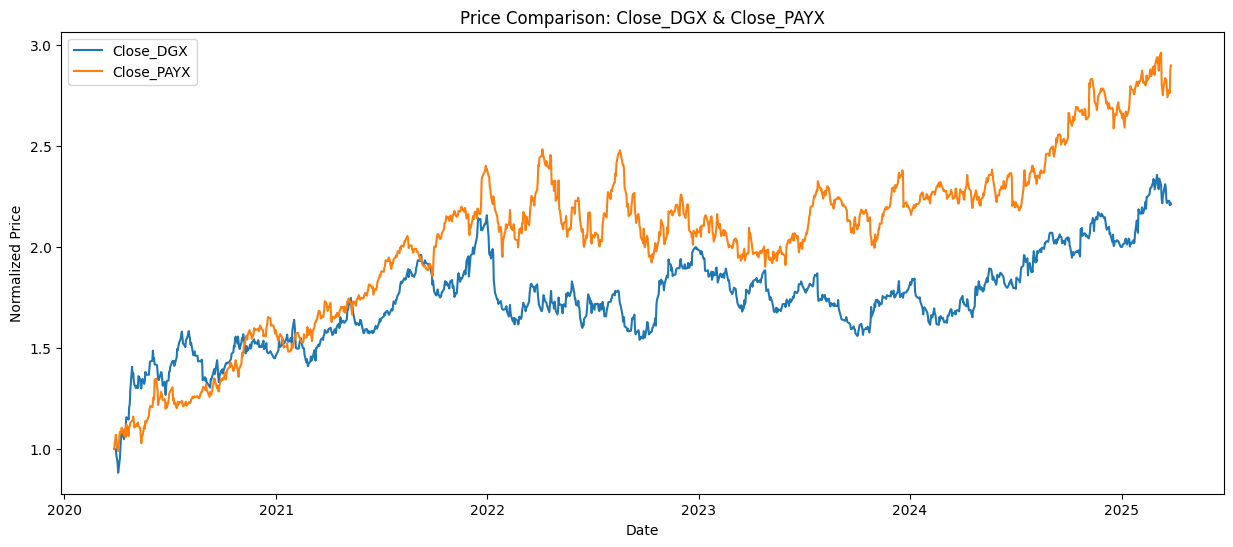

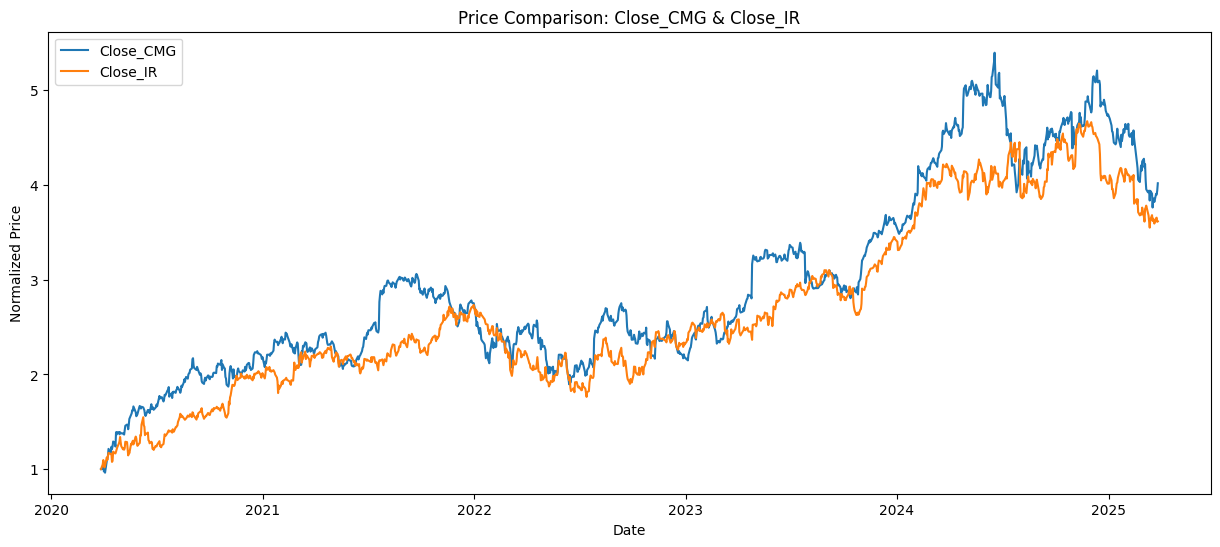

In [14]:

#for index, row in df_coint_pass.iterrows():       # Visualizasion all pairs

for index, row in df_coint_pass[:10].iterrows():   # Visualizasion only 10 pairs 
    base_asset = row['base_asset']
    compare_asset = row['compare_asset']
    
    # Normalize the values for each asset by dividing by the first value
    asset_1_values = stock_df[base_asset].values / stock_df[base_asset].iloc[0]
    asset_2_values = stock_df[compare_asset].values / stock_df[compare_asset].iloc[0]
    
    # Create a new figure for each pair
    plt.figure(figsize=(15, 6))
    
    # Plot with date as x-axis
    plt.plot(stock_df.index, asset_1_values, label=base_asset)
    plt.plot(stock_df.index, asset_2_values, label=compare_asset)
    
    # Add Labels and Legend
    plt.title(f"Price Comparison: {base_asset} & {compare_asset}")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    
    # Show plot
    plt.show()
